## 4) Iterative Pruning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torchvision
import time
import numpy as np
import copy
import sys
import os
from torchvision import datasets, models, transforms
from pathlib import Path
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torchvision.datasets import ImageFolder

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
Path("./data").mkdir(parents=True, exist_ok=True)
data_dir = Path('./data')
net_fn = Path('./net')
from torch.utils.data import DataLoader, random_split
# see if gdown is already downloaded
try:
    import gdown
    print("gdown is already installed, skipping installing command to save time......")
except ImportError:
    !conda install -y gdown

# Seed for reproducibility 
torch.manual_seed(0)
np.random.seed(0)

d:\Anaconda\envs\ese539\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  2.4.1+cu121
Torchvision Version:  0.19.1+cu121
gdown is already installed, skipping installing command to save time......


In [ ]:
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
Path("./data").mkdir(parents=True, exist_ok=True)
data_dir = Path('./data')
net_fn = Path('./net')

# see if gdown is already downloaded
try:
    import gdown
    print("gdown is already installed, skipping installing command to save time......")
except ImportError:
    !conda install -y gdown

PyTorch Version:  2.4.0
Torchvision Version:  0.19.0
gdown is already installed, skipping installing command to save time......


In [ ]:
REPOS = [
    [
        "1ZLyAcimq4sdZ0tl5yINudwSD843pAoOJ",
        "1EXwrSw6BWKMC4ovPRUyfuqeObuqsR-R5",
        "1rFIAJ9aLZrRCOeijo5mI0zWiEl3OMJ3j"
    ],
    [
        "1VLe11mOwsetC4IlL3wy8QexTat8XCool",
        "1_QwUcr3gmnjPFbKj0VrfOayVEWjRBS4Z",
        "1fgf9elhD7EhbKJn2NMnQS1iwQXesQZ3g"
    ],
    [
        "1BKC4kCB9sbwfRuhrAJWVEmbLoHx2vJWC",
        "1qhrcYgGKRf3Wt8YDU6aVRhzJDFHeqerP",
        "1JXym04uAoNGGpkBRzIn0yStZmRX0SmNu"
    ]
]

FILES = [
    Path("./data/ILSVRC2012_devkit_t12.tar.gz"),
    Path("./data/ILSVRC2012_devkit_t3.tar.gz"),
    Path("./data/ILSVRC2012_img_val.tar")
]

# Shuffle the order of repos
random.seed(int(time.time()))
random.shuffle(REPOS)

for repo_index, repo in enumerate(REPOS):
    missing_files = [str(file) for file in FILES if not file.is_file()]
    if not missing_files:
        print("All files are present. Skipping further downloads.")
        break

    print(f"Attempting download from repo {repo_index}")
    print(f"Missing files: {missing_files}")

    for file, url in zip(FILES, repo):
        if not file.is_file():
            print(f"Downloading {file}...")
            !gdown "{url}" -O "{str(file)}"

missing_files = [str(file) for file in FILES if not file.is_file()]
if missing_files:
    print(f"Failed to download all files. Still missing: {missing_files}")
    print(f"Contact TA team through EdStem with the output of this code block!", file=sys.stderr)
else:
    print("All files successfully downloaded.")

Attempting download from repo 0
Missing files: ['data/ILSVRC2012_devkit_t12.tar.gz', 'data/ILSVRC2012_devkit_t3.tar.gz', 'data/ILSVRC2012_img_val.tar']
Downloading...
From: https://drive.google.com/uc?id=1ZLyAcimq4sdZ0tl5yINudwSD843pAoOJ
To: /kaggle/working/data/ILSVRC2012_devkit_t12.tar.gz
100%|███████████████████████████████████████| 2.57M/2.57M [00:00<00:00, 174MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EXwrSw6BWKMC4ovPRUyfuqeObuqsR-R5
To: /kaggle/working/data/ILSVRC2012_devkit_t3.tar.gz
100%|██████████████████████████████████████| 22.4M/22.4M [00:00<00:00, 52.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1rFIAJ9aLZrRCOeijo5mI0zWiEl3OMJ3j
From (redirected): https://drive.google.com/uc?id=1rFIAJ9aLZrRCOeijo5mI0zWiEl3OMJ3j&confirm=t&uuid=e60ac4d0-8527-4843-aa42-f7901c62a97f
To: /kaggle/working/data/ILSVRC2012_img_val.tar
100%|███████████████████████████████████████| 6.74G/6.74G [01:03<00:00, 106MB/s]
All files are present. Skipping further downl

#### Helper Function

In [ ]:
# Put your reusable functions here.

# You can copy functions from previous labs and tutorials.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def evaluate(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    model.to(device)
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            if total >1024:
                break
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return 100 * correct / total


#  COUNT PARAMETERS
def count_params(model):

    model.to(device)
    tot_params = 0
    for layer_name, param in model.named_parameters():
        tot_params += torch.count_nonzero(param.data)
    
    return tot_params

def get_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    model_size = os.path.getsize("temp.p")/1e6
    os.remove('temp.p')
    return model_size


    
    
def training(model, train_loader, prune_percent,learning_rate=0.0001, epochs=5, iteration = float()):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    data_dir = "./models"
    # device = torch.device(device)
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)
    path  = "./models/model"+ str(prune_percent) +"_"+ str(iteration)
    os.makedirs(data_dir, exist_ok=True)

    # if os.path.exists(path):
    #     print("Trained model already exists loading those weigths!!")
    #     model.load_state_dict(torch.load(path))
    #     return

    # Create the directory if it doesn't exist
        # Fine-tune model after pruning
    for epoch in (range(epochs)):
        # print(f'Epoch: {epoch+1}/{epochs}')
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        # pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for i, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)

            # print(labels, " Labels")
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")
        print(evaluate(model, test_loader), " Evaluate ")

    # save model after each prune/train cylce

    # torch.save(model.state_dict(), path)

### Creating Dataloaders

In [ ]:
# Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create validation dataset
total_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)
train_size = int(0.8 * len(total_dataset))
val_size = len(total_dataset) - train_size

train_dataset, val_dataset = random_split(total_dataset, [train_size, val_size])


# Create validation dataloader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
print(f'Number of train images: {len(train_loader)}')
print(f'Number of validation images: {len(test_loader)}')

Number of train images: 625
Number of validation images: 157


### Baseline Model
-   Evaluating and Training 

In [ ]:
baseline_model = models.vgg16(pretrained = True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 196MB/s]


In [ ]:
baseline_acc_before = evaluate(baseline_model, test_loader)
print(baseline_acc_before, "Baseline Accuracy without Retraining")

  0%|          | 0/157 [00:00<?, ?it/s]

71.78308823529412 Baseline Accuracy without Retraining


In [ ]:

training(baseline_model, train_loader, prune_percent=0)
baseline_acc_after_training = evaluate(baseline_model, test_loader)
model_path = "./models/model0_"+ str(0.0)
torch.save(baseline_model.state_dict(), model_path)
print("Baseline Accuracy after retraining is: ", baseline_acc_after_training)


cuda


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 1.2917, Accuracy: 68.45%


  0%|          | 0/157 [00:00<?, ?it/s]

71.23161764705883  Evaluate 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 1.2677, Accuracy: 68.75%


  0%|          | 0/157 [00:00<?, ?it/s]

71.13970588235294  Evaluate 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 1.2465, Accuracy: 69.16%


  0%|          | 0/157 [00:00<?, ?it/s]

71.32352941176471  Evaluate 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 1.2372, Accuracy: 69.30%


  0%|          | 0/157 [00:00<?, ?it/s]

71.59926470588235  Evaluate 


  0%|          | 0/625 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 1.2278, Accuracy: 69.33%


  0%|          | 0/157 [00:00<?, ?it/s]

71.59926470588235  Evaluate 


  0%|          | 0/157 [00:00<?, ?it/s]

Baseline Accuracy after retraining is:  71.59926470588235


### Some More Helper Function
- _prune_by_x()_: prunes x percent
- _prune_by_x_remove()_: makes the prune permament
- _iterative_pruning()_: iteratively prune and retrain

In [ ]:
def prune_by_x(model, percent):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''
    for name, module in model.named_modules():
        # this will remove percent connections in linear layers
        # print(module, '\n')
        if isinstance(module, torch.nn.Conv2d) and name !='output':
            # print('hey')
            torch.nn.utils.prune.l1_unstructured(module = module, name = 'weight', amount= percent)
            # torch.nn.utils.prune.remove(module, 'weight')


        if isinstance(module, torch.nn.Linear) and name !='output':
            torch.nn.utils.prune.l1_unstructured(module = module, name = 'weight', amount= percent)
            # torch.nn.utils.prune.remove(module, 'weight')

        # this will remove percent connections in output layers
        elif isinstance(module, torch.nn.Linear) and name == 'output':
            torch.nn.utils.prune.l1_unstructured(module = module, name = 'weight', amount = percent)
            # torch.nn.utils.prune.remove(module, 'weight')

def prune_by_x_remove(model):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''
    for name, module in model.named_modules():
        # this will remove percent connections in linear layers
        # print(module, '\n')
        if isinstance(module, torch.nn.Conv2d) and name !='output':
            # print('hey')
            # torch.nn.utils.prune.l1_unstructured(module = module, name = 'weight', amount= percent)
            torch.nn.utils.prune.remove(module, 'weight')


        if isinstance(module, torch.nn.Linear) and name !='output':
            # torch.nn.utils.prune.l1_unstructured(module = module, name = 'weight', amount= percent)
            torch.nn.utils.prune.remove(module, 'weight')

        # this will remove percent connections in output layers
        elif isinstance(module, torch.nn.Linear) and name == 'output':
            # torch.nn.utils.prune.l1_unstructured(module = module, name = 'weight', amount = percent)
            torch.nn.utils.prune.remove(module, 'weight')


def iterative_pruning(model, train_loader, iterations=10, prune_amount=0.2, retrain=False, accuracy_threshold = 0):
    model = model.to(device)
    acc_hist = []
    
    for i in range(iterations):
        print(f"Iteration {i + 1}/{iterations} - Pruning {prune_amount * 100:.0f}% of weights")
        prune_by_x(model, prune_amount)
        
        # for name, module in model.named_modules():
        #     if hasattr(module, 'weight'):
        #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")
                
        if retrain:
            print(f"Retraining after iteration {i + 1}...")
            prev_model = model
            training(model, train_loader, prune_percent=prune_amount, iteration = i, epochs = 5)
            
            # Ideally should have a validation dataset and not test dataset
            acc = evaluate(model, test_loader)
            print(f"Validation Accuracy after {i+1} iteration: {acc}")
            acc_hist.append(acc)
            if 100*accuracy_threshold != 0 and acc < accuracy_threshold:
                print(f"Current accuracy {acc}% below threshold Iterative Pruning Stopped at iteration {i+1}")
                break
                

    # Final pruning and check sparsity
    prune_by_x_remove(model)
    # path  = "./models/model"+ str(prune_amount) +"_"+ str(i)
    # torch.save(model.state_dict(), path)

    return np.array(acc_hist)
    # for name, module in model.named_modules():
    #     if hasattr(module, 'weight'):
    #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")

    # if retrain:
    #     print(f"Retraining final model after pruning...")
    #     training(model, train_loader, prune_percent=prune_amount)


### Running iterative Pruning with Layer-Wise Pruning

In [ ]:
prune_rate_list = [0.1] # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
model_path = "./models/model0_"+ str(0.0)

for prune_rate in prune_rate_list:

    model = models.vgg16(pretrained=True)#TODO: load pretr  ained model
    # model.load_state_dict(torch.load(model_path))
    # convs_to_prune = () #TODO: Add conv layers to prune

    layer_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate

    # TODO Run validation on the pruned model (without retraining)
    print("Evaluating before training...")
    top1_acc_notrain = evaluate(model, test_loader)
    layer_pruning[prune_rate] = {
        'model_notrain': model,
        'top1_acc_notrain': top1_acc_notrain,
   
    }

    print(f'Top1 accuracy for prune amount without iterative pruning {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_notrain"]}%')
    # print(f'Top1 accuracy (rel) for prune amount without retraining {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_rel_notrain"]}%')

    # Iterative pruning and training. 
    # acc_hist will store validation accuracy indexed by the number of iterations. 
    acc_hist = iterative_pruning(model, train_loader, iterations=25, prune_amount=prune_rate, accuracy_threshold= 60, retrain=True )

    
    top1_acc_train = evaluate(model, test_loader)
    layer_pruning[prune_rate].update({
        'model_train': model,
        'top1_acc_train': top1_acc_train,
        'acc_hist_per_iteration':acc_hist
    })

    print(f'Top1 accuracy for prune amount with retraining {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_train"]}%')

    print('-------------------------------------------')

Evaluating before training...


 20%|██        | 16/79 [00:10<00:42,  1.48it/s]


Top1 accuracy for prune amount without iterative pruning 10.0%: 72.75390625%
Iteration 1/25 - Pruning 10% of weights
Retraining after iteration 1...
cuda


100%|██████████| 704/704 [15:17<00:00,  1.30s/it]


Epoch 1/7 - Loss: 1.8935, Accuracy: 56.27%


 20%|██        | 16/79 [00:11<00:45,  1.40it/s]


64.74609375  Evaluate 


100%|██████████| 704/704 [15:23<00:00,  1.31s/it]


Epoch 2/7 - Loss: 1.6708, Accuracy: 60.20%


 20%|██        | 16/79 [00:11<00:46,  1.36it/s]


66.6015625  Evaluate 


100%|██████████| 704/704 [15:25<00:00,  1.32s/it]


Epoch 3/7 - Loss: 1.5975, Accuracy: 61.52%


 20%|██        | 16/79 [00:12<00:47,  1.32it/s]


67.67578125  Evaluate 


100%|██████████| 704/704 [15:30<00:00,  1.32s/it]


Epoch 4/7 - Loss: 1.5541, Accuracy: 62.23%


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


67.578125  Evaluate 


100%|██████████| 704/704 [15:22<00:00,  1.31s/it]


Epoch 5/7 - Loss: 1.5278, Accuracy: 62.92%


 20%|██        | 16/79 [00:11<00:45,  1.39it/s]


67.96875  Evaluate 


100%|██████████| 704/704 [15:22<00:00,  1.31s/it]


Epoch 6/7 - Loss: 1.5018, Accuracy: 63.39%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


68.1640625  Evaluate 


100%|██████████| 704/704 [15:19<00:00,  1.31s/it]


Epoch 7/7 - Loss: 1.4758, Accuracy: 63.92%


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


68.65234375  Evaluate 


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


Validation Accuracy after 1 iteration: 68.65234375
Iteration 2/25 - Pruning 10% of weights
Retraining after iteration 2...
cuda


100%|██████████| 704/704 [15:15<00:00,  1.30s/it]


Epoch 1/7 - Loss: 2.5305, Accuracy: 44.48%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


54.98046875  Evaluate 


100%|██████████| 704/704 [15:14<00:00,  1.30s/it]


Epoch 2/7 - Loss: 2.1635, Accuracy: 50.16%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


57.421875  Evaluate 


100%|██████████| 704/704 [15:13<00:00,  1.30s/it]


Epoch 3/7 - Loss: 2.0455, Accuracy: 52.36%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


58.30078125  Evaluate 


100%|██████████| 704/704 [15:14<00:00,  1.30s/it]


Epoch 4/7 - Loss: 1.9609, Accuracy: 53.73%


 20%|██        | 16/79 [00:11<00:46,  1.37it/s]


58.69140625  Evaluate 


100%|██████████| 704/704 [15:16<00:00,  1.30s/it]


Epoch 5/7 - Loss: 1.9061, Accuracy: 54.91%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


59.86328125  Evaluate 


100%|██████████| 704/704 [15:15<00:00,  1.30s/it]


Epoch 6/7 - Loss: 1.8564, Accuracy: 55.96%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


60.15625  Evaluate 


100%|██████████| 704/704 [15:14<00:00,  1.30s/it]


Epoch 7/7 - Loss: 1.8101, Accuracy: 56.79%


 20%|██        | 16/79 [00:11<00:45,  1.39it/s]


61.1328125  Evaluate 


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


Validation Accuracy after 2 iteration: 61.1328125
Iteration 3/25 - Pruning 10% of weights
Retraining after iteration 3...
cuda


100%|██████████| 704/704 [15:06<00:00,  1.29s/it]


Epoch 1/7 - Loss: 3.2188, Accuracy: 32.53%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


43.65234375  Evaluate 


100%|██████████| 704/704 [15:07<00:00,  1.29s/it]


Epoch 2/7 - Loss: 2.7247, Accuracy: 39.71%


 20%|██        | 16/79 [00:11<00:44,  1.42it/s]


47.265625  Evaluate 


100%|██████████| 704/704 [15:08<00:00,  1.29s/it]


Epoch 3/7 - Loss: 2.5442, Accuracy: 42.53%


 20%|██        | 16/79 [00:11<00:45,  1.40it/s]


49.0234375  Evaluate 


100%|██████████| 704/704 [15:10<00:00,  1.29s/it]


Epoch 4/7 - Loss: 2.4262, Accuracy: 44.49%


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


49.8046875  Evaluate 


100%|██████████| 704/704 [15:10<00:00,  1.29s/it]


Epoch 5/7 - Loss: 2.3408, Accuracy: 46.16%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


52.05078125  Evaluate 


100%|██████████| 704/704 [15:09<00:00,  1.29s/it]


Epoch 6/7 - Loss: 2.2704, Accuracy: 47.41%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


52.63671875  Evaluate 


100%|██████████| 704/704 [15:06<00:00,  1.29s/it]


Epoch 7/7 - Loss: 2.2155, Accuracy: 48.39%


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


53.515625  Evaluate 


 20%|██        | 16/79 [00:11<00:44,  1.42it/s]


Validation Accuracy after 3 iteration: 53.515625
Iteration 4/25 - Pruning 10% of weights
Retraining after iteration 4...
cuda


100%|██████████| 704/704 [15:00<00:00,  1.28s/it]


Epoch 1/7 - Loss: 3.7231, Accuracy: 24.69%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


35.83984375  Evaluate 


100%|██████████| 704/704 [14:59<00:00,  1.28s/it]


Epoch 2/7 - Loss: 3.2442, Accuracy: 30.39%


 20%|██        | 16/79 [00:11<00:44,  1.43it/s]


38.18359375  Evaluate 


100%|██████████| 704/704 [14:59<00:00,  1.28s/it]


Epoch 3/7 - Loss: 3.0427, Accuracy: 33.74%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


40.8203125  Evaluate 


100%|██████████| 704/704 [15:00<00:00,  1.28s/it]


Epoch 4/7 - Loss: 2.9054, Accuracy: 35.88%


 20%|██        | 16/79 [00:11<00:44,  1.42it/s]


42.48046875  Evaluate 


100%|██████████| 704/704 [14:59<00:00,  1.28s/it]


Epoch 5/7 - Loss: 2.8007, Accuracy: 37.53%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


43.5546875  Evaluate 


100%|██████████| 704/704 [14:59<00:00,  1.28s/it]


Epoch 6/7 - Loss: 2.7287, Accuracy: 38.87%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


45.3125  Evaluate 


100%|██████████| 704/704 [15:00<00:00,  1.28s/it]


Epoch 7/7 - Loss: 2.6589, Accuracy: 40.02%


 20%|██        | 16/79 [00:11<00:44,  1.43it/s]


45.8984375  Evaluate 


 20%|██        | 16/79 [00:11<00:45,  1.39it/s]


Validation Accuracy after 4 iteration: 45.8984375
Iteration 5/25 - Pruning 10% of weights
Retraining after iteration 5...
cuda


100%|██████████| 704/704 [14:55<00:00,  1.27s/it]


Epoch 1/7 - Loss: 4.3777, Accuracy: 16.35%


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


27.24609375  Evaluate 


100%|██████████| 704/704 [14:53<00:00,  1.27s/it]


Epoch 2/7 - Loss: 3.7544, Accuracy: 22.94%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


31.15234375  Evaluate 


100%|██████████| 704/704 [14:54<00:00,  1.27s/it]


Epoch 3/7 - Loss: 3.5346, Accuracy: 25.55%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


33.69140625  Evaluate 


100%|██████████| 704/704 [14:54<00:00,  1.27s/it]


Epoch 4/7 - Loss: 3.3769, Accuracy: 27.73%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


35.3515625  Evaluate 


100%|██████████| 704/704 [14:55<00:00,  1.27s/it]


Epoch 5/7 - Loss: 3.2670, Accuracy: 29.34%


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


37.20703125  Evaluate 


100%|██████████| 704/704 [14:53<00:00,  1.27s/it]


Epoch 6/7 - Loss: 3.1852, Accuracy: 30.71%


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


37.5  Evaluate 


100%|██████████| 704/704 [14:52<00:00,  1.27s/it]


Epoch 7/7 - Loss: 3.1004, Accuracy: 32.12%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


39.55078125  Evaluate 


 20%|██        | 16/79 [00:11<00:44,  1.42it/s]


Validation Accuracy after 5 iteration: 39.55078125
Iteration 6/25 - Pruning 10% of weights
Retraining after iteration 6...
cuda


100%|██████████| 704/704 [14:50<00:00,  1.27s/it]


Epoch 1/7 - Loss: 4.6336, Accuracy: 12.43%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


20.99609375  Evaluate 


100%|██████████| 704/704 [14:53<00:00,  1.27s/it]


Epoch 2/7 - Loss: 4.1430, Accuracy: 17.12%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


25.68359375  Evaluate 


100%|██████████| 704/704 [14:52<00:00,  1.27s/it]


Epoch 3/7 - Loss: 3.9395, Accuracy: 19.43%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


27.34375  Evaluate 


100%|██████████| 704/704 [14:52<00:00,  1.27s/it]


Epoch 4/7 - Loss: 3.7988, Accuracy: 21.44%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


27.83203125  Evaluate 


100%|██████████| 704/704 [14:52<00:00,  1.27s/it]


Epoch 5/7 - Loss: 3.6799, Accuracy: 23.05%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


30.56640625  Evaluate 


100%|██████████| 704/704 [14:51<00:00,  1.27s/it]


Epoch 6/7 - Loss: 3.5874, Accuracy: 24.28%


 20%|██        | 16/79 [00:10<00:43,  1.46it/s]


31.0546875  Evaluate 


100%|██████████| 704/704 [14:51<00:00,  1.27s/it]


Epoch 7/7 - Loss: 3.5095, Accuracy: 25.31%


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


32.51953125  Evaluate 


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


Validation Accuracy after 6 iteration: 32.51953125
Desired Sparsity Reached!!!


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]

Top1 accuracy for prune amount with retraining 10.0%: 32.51953125%
-------------------------------------------


### Saving Variables for Future Use

In [ ]:
np.save("Acc_history", layer_pruning[0.1]['acc_hist_per_iteration'])
np.save("baseline_acc_after_training", baseline_acc_after_training)
np.save("baseline_acc_before_training", baseline_acc_before)

### Validating only Pruned Network (Not-Retrained)

In [ ]:
def iterative_pruning(model, train_loader, iterations=10, prune_amount=0.2):
    model = model.to(device)
    acc_hist = []
    
    for i in range(iterations):
        print(f"Iteration {i + 1}/{iterations} - Pruning {prune_amount * 100:.0f}% of weights")
        prune_by_x(model, prune_amount)
        acc_hist.append(evaluate(model, test_loader))
        
                
                

    # Final pruning and check sparsity
    prune_by_x_remove(model)
    # path  = "./models/model"+ str(prune_amount) +"_"+ str(i)
    # torch.save(model.state_dict(), path)

    return np.array(acc_hist)
    # for name, module in model.named_modules():
    #     if hasattr(module, 'weight'):
    #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")

    # if retrain:
    #     print(f"Retraining final model after pruning...")
    #     training(model, train_loader, prune_percent=prune_amount)


In [ ]:
prune_rate_list = [0.10] # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
model_path = "./models/model0_"+ str(0.0)
device = torch.device('cuda')
for prune_rate in prune_rate_list:

    model = models.vgg16(pretrained=True)#TODO: load pretr  ained model
    # model.load_state_dict(torch.load(model_path))
    # convs_to_prune = () #TODO: Add conv layers to prune

   

   
    acc_hist_prune_only = iterative_pruning(model, iterations=6, prune_amount=prune_rate )

    
np.save("Acc_history_only_prune", acc_hist_prune_only)

Iteration 1/6 - Pruning 10% of weights


 20%|██        | 16/79 [00:19<01:17,  1.23s/it]


Iteration 2/6 - Pruning 10% of weights


 20%|██        | 16/79 [00:10<00:41,  1.54it/s]


Iteration 3/6 - Pruning 10% of weights


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


Iteration 4/6 - Pruning 10% of weights


 20%|██        | 16/79 [00:10<00:40,  1.55it/s]


Iteration 5/6 - Pruning 10% of weights


 20%|██        | 16/79 [00:10<00:40,  1.57it/s]


Iteration 6/6 - Pruning 10% of weights


 20%|██        | 16/79 [00:10<00:41,  1.52it/s]


### Loading the results and Plotting them

In [ ]:
acc_hist = np.load("Acc_history.npy")
basline_acc_before = np.load("baseline_acc_before_training.npy")
basline_acc_after = np.load("baseline_acc_after_training.npy")
acc_hist_no_retrain = np.load('Acc_history_only_prune.npy')

# creating x axis
x_axis = []
weigths = 100
for i in range(6):
    
    x_axis.append(round(100- weigths*(100-10)/100, 2))
    weigths = weigths*(100-10)/100


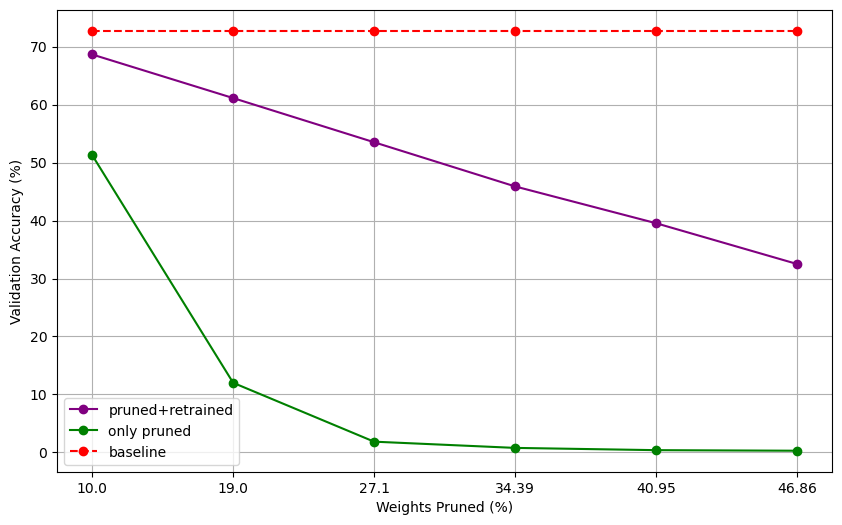

In [ ]:
plt.figure(figsize = (10, 6))
plt.plot(range(6), acc_hist, marker = 'o', color = 'purple', label = "pruned+retrained")
plt.plot(range(6), acc_hist_prune_only, marker = 'o', color = 'g', label = "only pruned")

plt.plot(basline_acc_before*np.ones(len(acc_hist)), '--', color = 'r', label = 'baseline', marker = 'o')

plt.xticks(range(6), x_axis)
plt.grid()
plt.xlabel("Weights Pruned (%)")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.savefig("Acc VS weights_channel_pruning_10percent")

### Layer Channel Pruning

In [ ]:
def prune_by_x(model, percent):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''

    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.ln_structured(layer, name='weight', amount=percent, n=1, dim=0)

    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.Linear) and i < len(model.classifier) - 1:
            prune.ln_structured(layer, name='weight', amount=percent , n=1, dim=0)


def prune_by_x_remove(model):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.remove(layer, 'weight')
    
    
    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.Linear) and i < len(model.classifier) - 1:
            prune.remove(layer, 'weight')

In [ ]:
def iterative_pruning(model, train_loader, iterations=10, prune_amount=0.2, retrain=False, accuracy_threshold = 0):
    model = model.to(device)
    acc_hist = []
    
    for i in range(iterations):
        print(f"Iteration {i + 1}/{iterations} - Pruning {prune_amount * 100:.0f}% of weights")
        prune_by_x(model, prune_amount)
        
        # for name, module in model.named_modules():
        #     if hasattr(module, 'weight'):
        #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")
                
        if retrain:
            print(f"Retraining after iteration {i + 1}...")
            prev_model = model
            training(model, train_loader, prune_percent=prune_amount, iteration = i, epochs = 5)
            
            # Ideally should have a validation dataset and not test dataset
            acc = evaluate(model, test_loader)
            print(f"Validation Accuracy after {i+1} iteration: {acc}")
            acc_hist.append(acc)
            np.save("acc_hist", acc_hist)
            if 100*accuracy_threshold != 0 and 100-100*(1-0.15)**(i+1) > accuracy_threshold:
                print(f'Desired Sparsity Reached!!!')
                break
                print(f"Current accuracy {acc}% below threshold Iterative Pruning Stopped at iteration {i+1}")
                break
                

    # Final pruning and check sparsity
    prune_by_x_remove(model)
    # path  = "./models/model"+ str(prune_amount) +"_"+ str(i)
    # torch.save(model.state_dict(), path)

    return np.array(acc_hist)
    # for name, module in model.named_modules():
    #     if hasattr(module, 'weight'):
    #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")

    # if retrain:
    #     print(f"Retraining final model after pruning...")
    #     training(model, train_loader, prune_percent=prune_amount)


In [ ]:
prune_rate_list = [0.15] # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
model_path = "./models/model0_"+ str(0.0)

for prune_rate in prune_rate_list:

    model = models.vgg16(pretrained=True)#TODO: load pretr  ained model
    # model.load_state_dict(torch.load(model_path))
    # convs_to_prune = () #TODO: Add conv layers to prune

    layer_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate

    # TODO Run validation on the pruned model (without retraining)
    print("Evaluating before training...")
    top1_acc_notrain = evaluate(model, test_loader)
    layer_pruning[prune_rate] = {
        'model_notrain': model,
        'top1_acc_notrain': top1_acc_notrain,
   
    }

    print(f'Top1 accuracy for prune amount without iterative pruning {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_notrain"]}%')
    # print(f'Top1 accuracy (rel) for prune amount without retraining {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_rel_notrain"]}%')

    # Iterative pruning and training. 
    # acc_hist will store validation accuracy indexed by the number of iterations. 
    acc_hist = iterative_pruning(model, train_loader, iterations=25, prune_amount=prune_rate, accuracy_threshold= 60, retrain=True )

    
    top1_acc_train = evaluate(model, test_loader)
    layer_pruning[prune_rate].update({
        'model_train': model,
        'top1_acc_train': top1_acc_train,
        'acc_hist_per_iteration':acc_hist
    })

    print(f'Top1 accuracy for prune amount with retraining {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_train"]}%')

    print('-------------------------------------------')

Evaluating before training...


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


Top1 accuracy for prune amount without iterative pruning 15.0%: 72.75390625%
Iteration 1/25 - Pruning 15% of weights
Retraining after iteration 1...
cuda


100%|██████████| 704/704 [15:18<00:00,  1.30s/it]


Epoch 1/5 - Loss: 2.5660, Accuracy: 44.47%


 20%|██        | 16/79 [00:11<00:45,  1.39it/s]


55.6640625  Evaluate 


100%|██████████| 704/704 [15:33<00:00,  1.33s/it]


Epoch 2/5 - Loss: 2.0794, Accuracy: 52.30%


 20%|██        | 16/79 [00:11<00:45,  1.40it/s]


59.1796875  Evaluate 


100%|██████████| 704/704 [15:34<00:00,  1.33s/it]


Epoch 3/5 - Loss: 1.9364, Accuracy: 54.66%


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


60.64453125  Evaluate 


100%|██████████| 704/704 [15:37<00:00,  1.33s/it]


Epoch 4/5 - Loss: 1.8520, Accuracy: 56.36%


 20%|██        | 16/79 [00:11<00:45,  1.37it/s]


63.37890625  Evaluate 


100%|██████████| 704/704 [15:40<00:00,  1.34s/it]


Epoch 5/5 - Loss: 1.7959, Accuracy: 57.52%


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


63.57421875  Evaluate 


 20%|██        | 16/79 [00:11<00:45,  1.38it/s]


Validation Accuracy after 1 iteration: 63.57421875
Iteration 2/25 - Pruning 15% of weights
Retraining after iteration 2...
cuda


100%|██████████| 704/704 [15:25<00:00,  1.31s/it]


Epoch 1/5 - Loss: 4.0006, Accuracy: 22.94%


 20%|██        | 16/79 [00:11<00:45,  1.37it/s]


33.69140625  Evaluate 


100%|██████████| 704/704 [15:26<00:00,  1.32s/it]


Epoch 2/5 - Loss: 3.2371, Accuracy: 31.81%


 20%|██        | 16/79 [00:11<00:46,  1.37it/s]


39.55078125  Evaluate 


100%|██████████| 704/704 [15:25<00:00,  1.32s/it]


Epoch 3/5 - Loss: 2.9375, Accuracy: 35.93%


 20%|██        | 16/79 [00:11<00:45,  1.40it/s]


43.9453125  Evaluate 


100%|██████████| 704/704 [15:25<00:00,  1.31s/it]


Epoch 4/5 - Loss: 2.7598, Accuracy: 39.06%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


46.09375  Evaluate 


100%|██████████| 704/704 [15:23<00:00,  1.31s/it]


Epoch 5/5 - Loss: 2.6349, Accuracy: 41.25%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


47.65625  Evaluate 


 20%|██        | 16/79 [00:11<00:45,  1.39it/s]


Validation Accuracy after 2 iteration: 47.65625
Iteration 3/25 - Pruning 15% of weights
Retraining after iteration 3...
cuda


100%|██████████| 704/704 [15:14<00:00,  1.30s/it]


Epoch 1/5 - Loss: 5.0064, Accuracy: 10.63%


 20%|██        | 16/79 [00:11<00:44,  1.40it/s]


19.7265625  Evaluate 


100%|██████████| 704/704 [15:13<00:00,  1.30s/it]


Epoch 2/5 - Loss: 4.3166, Accuracy: 16.17%


 20%|██        | 16/79 [00:11<00:43,  1.43it/s]


24.51171875  Evaluate 


100%|██████████| 704/704 [15:13<00:00,  1.30s/it]


Epoch 3/5 - Loss: 3.9862, Accuracy: 19.95%


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


27.05078125  Evaluate 


100%|██████████| 704/704 [15:14<00:00,  1.30s/it]


Epoch 4/5 - Loss: 3.7582, Accuracy: 22.75%


 20%|██        | 16/79 [00:11<00:45,  1.39it/s]


29.4921875  Evaluate 


100%|██████████| 704/704 [15:14<00:00,  1.30s/it]


Epoch 5/5 - Loss: 3.5997, Accuracy: 24.82%


 20%|██        | 16/79 [00:11<00:44,  1.42it/s]


32.421875  Evaluate 


 20%|██        | 16/79 [00:11<00:44,  1.41it/s]


Validation Accuracy after 3 iteration: 32.421875
Iteration 4/25 - Pruning 15% of weights
Retraining after iteration 4...
cuda


100%|██████████| 704/704 [15:01<00:00,  1.28s/it]


Epoch 1/5 - Loss: 5.7607, Accuracy: 4.09%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


8.0078125  Evaluate 


100%|██████████| 704/704 [15:05<00:00,  1.29s/it]


Epoch 2/5 - Loss: 5.2004, Accuracy: 7.03%


 20%|██        | 16/79 [00:11<00:43,  1.43it/s]


12.5  Evaluate 


100%|██████████| 704/704 [15:05<00:00,  1.29s/it]


Epoch 3/5 - Loss: 4.8976, Accuracy: 9.19%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


14.6484375  Evaluate 


100%|██████████| 704/704 [15:06<00:00,  1.29s/it]


Epoch 4/5 - Loss: 4.6747, Accuracy: 10.82%


 20%|██        | 16/79 [00:11<00:44,  1.43it/s]


16.6015625  Evaluate 


100%|██████████| 704/704 [15:05<00:00,  1.29s/it]


Epoch 5/5 - Loss: 4.4958, Accuracy: 12.81%


 20%|██        | 16/79 [00:11<00:44,  1.43it/s]


20.3125  Evaluate 


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


Validation Accuracy after 4 iteration: 20.3125
Iteration 5/25 - Pruning 15% of weights
Retraining after iteration 5...
cuda


100%|██████████| 704/704 [14:52<00:00,  1.27s/it]


Epoch 1/5 - Loss: 6.3657, Accuracy: 1.12%


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


2.734375  Evaluate 


100%|██████████| 704/704 [14:53<00:00,  1.27s/it]


Epoch 2/5 - Loss: 5.9669, Accuracy: 2.27%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


5.078125  Evaluate 


100%|██████████| 704/704 [14:52<00:00,  1.27s/it]


Epoch 3/5 - Loss: 5.7284, Accuracy: 3.01%


 20%|██        | 16/79 [00:10<00:43,  1.46it/s]


6.93359375  Evaluate 


100%|██████████| 704/704 [14:53<00:00,  1.27s/it]


Epoch 4/5 - Loss: 5.5429, Accuracy: 3.86%


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


7.12890625  Evaluate 


100%|██████████| 704/704 [14:53<00:00,  1.27s/it]


Epoch 5/5 - Loss: 5.3885, Accuracy: 4.71%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


9.27734375  Evaluate 


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


Validation Accuracy after 5 iteration: 9.27734375
Iteration 6/25 - Pruning 15% of weights
Retraining after iteration 6...
cuda


100%|██████████| 704/704 [14:45<00:00,  1.26s/it]


Epoch 1/5 - Loss: 6.7622, Accuracy: 0.38%


 20%|██        | 16/79 [00:11<00:43,  1.43it/s]


1.07421875  Evaluate 


100%|██████████| 704/704 [14:46<00:00,  1.26s/it]


Epoch 2/5 - Loss: 6.4806, Accuracy: 0.74%


 20%|██        | 16/79 [00:10<00:43,  1.46it/s]


1.7578125  Evaluate 


100%|██████████| 704/704 [14:46<00:00,  1.26s/it]


Epoch 3/5 - Loss: 6.2886, Accuracy: 1.10%


 20%|██        | 16/79 [00:11<00:43,  1.45it/s]


1.66015625  Evaluate 


100%|██████████| 704/704 [14:46<00:00,  1.26s/it]


Epoch 4/5 - Loss: 6.1400, Accuracy: 1.29%


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]


2.63671875  Evaluate 


100%|██████████| 704/704 [14:46<00:00,  1.26s/it]


Epoch 5/5 - Loss: 6.0376, Accuracy: 1.58%


 20%|██        | 16/79 [00:10<00:43,  1.46it/s]


2.9296875  Evaluate 


 20%|██        | 16/79 [00:11<00:43,  1.43it/s]


Validation Accuracy after 6 iteration: 2.9296875
Desired Sparsity Reached!!!


 20%|██        | 16/79 [00:11<00:43,  1.44it/s]

Top1 accuracy for prune amount with retraining 15.0%: 2.9296875%
-------------------------------------------


### Just Pruning and not Retraining

In [ ]:
def prune_by_x(model, percent):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''

    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.ln_structured(layer, name='weight', amount=percent, n=1, dim=0)

    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.Linear) and i < len(model.classifier) - 1:
            prune.ln_structured(layer, name='weight', amount=percent , n=1, dim=0)


def prune_by_x_remove(model):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.remove(layer, 'weight')
    
    
    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.Linear) and i < len(model.classifier) - 1:
            prune.remove(layer, 'weight')

In [ ]:
def iterative_pruning(model, iterations=10, prune_amount=0.2):
    model = model.to(device)
    acc_hist = []
    
    for i in range(iterations):
        print(f"Iteration {i + 1}/{iterations} - Pruning {prune_amount * 100:.0f}% of weights")
        prune_by_x(model, prune_amount)
        acc_hist.append(evaluate(model, test_loader))
        
                
                

    # Final pruning and check sparsity
    prune_by_x_remove(model)
    # path  = "./models/model"+ str(prune_amount) +"_"+ str(i)
    # torch.save(model.state_dict(), path)

    return np.array(acc_hist)
    # for name, module in model.named_modules():
    #     if hasattr(module, 'weight'):
    #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")

    # if retrain:
    #     print(f"Retraining final model after pruning...")
    #     training(model, train_loader, prune_percent=prune_amount)


In [ ]:
prune_rate_list = [0.15] # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
model_path = "./models/model0_"+ str(0.0)

for prune_rate in prune_rate_list:

    model = models.vgg16(pretrained=True)#TODO: load pretr  ained model
    # model.load_state_dict(torch.load(model_path))
    # convs_to_prune = () #TODO: Add conv layers to prune

   

   
    acc_hist_prune_only = iterative_pruning(model, iterations=6, prune_amount=prune_rate )

    
 

Iteration 1/6 - Pruning 15% of weights


 20%|██        | 16/79 [00:24<01:36,  1.53s/it]


Iteration 2/6 - Pruning 15% of weights


 20%|██        | 16/79 [00:11<00:46,  1.36it/s]


Iteration 3/6 - Pruning 15% of weights


 20%|██        | 16/79 [00:14<00:57,  1.09it/s]


Iteration 4/6 - Pruning 15% of weights


 20%|██        | 16/79 [00:14<00:55,  1.13it/s]


Iteration 5/6 - Pruning 15% of weights


 20%|██        | 16/79 [00:12<00:48,  1.29it/s]


Iteration 6/6 - Pruning 15% of weights


 20%|██        | 16/79 [00:13<00:51,  1.21it/s]


In [ ]:
acc_hist = np.load("acc_hist.npy")
basline_acc_before = 72.75
# basline_acc_before = np.load("baseline_acc_before_training.npy")
# basline_acc_after = np.load("baseline_acc_after_training.npy")

In [ ]:
x_axis = []
weigths = 100
for i in range(6):
    
    x_axis.append(round(100- weigths*(100-15)/100, 2))
    weigths = weigths*(100-15)/100


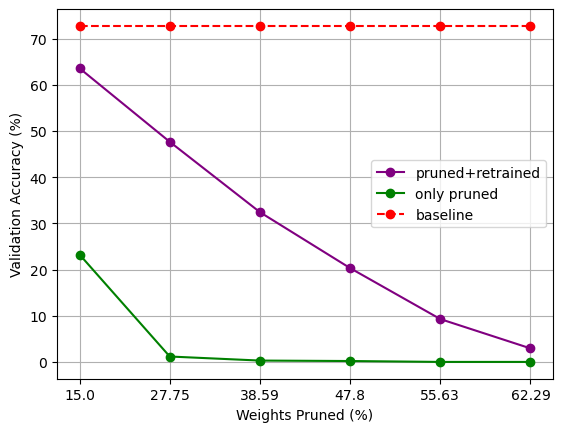

In [ ]:
plt.plot(range(6), acc_hist, marker = 'o', color = 'purple', label = "pruned+retrained")
plt.plot(range(6), acc_hist_prune_only, marker = 'o', color = 'g', label = "only pruned")

plt.plot(basline_acc_before*np.ones(len(acc_hist)), '--', color = 'r', label = 'baseline', marker = 'o')

plt.xticks(range(6), x_axis)
plt.grid()
plt.xlabel("Weights Pruned (%)")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.savefig("Acc VS weights_channel_pruning")

## Extension - Transfer Learning

In [ ]:
def prune_by_x(model, percent):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''

    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.ln_structured(layer, name='weight', amount=percent, n=1, dim=0)

    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.Linear) and i < len(model.classifier) - 1:
            prune.ln_structured(layer, name='weight', amount=percent , n=1, dim=0)


def prune_by_x_remove(model):
    '''
        This will prune by percent, Conv2D and Linear layers. and make that permanent
    '''
    for layer in model.features:
        if isinstance(layer, nn.Conv2d):
            prune.remove(layer, 'weight')
    
    
    for i, layer in enumerate(model.classifier):
        if isinstance(layer, nn.Linear) and i < len(model.classifier) - 1:
            prune.remove(layer, 'weight')

### Creating Dataloaders

In [ ]:
root = "./melanoma/"
train = "melanoma_cancer_dataset/train"
test = "melanoma_cancer_dataset/test"

target_size = (32, 32)
batch_size = 32
num_classes = 2

train_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Resize(target_size, antialias = True),
transforms.ColorJitter(brightness = (0.85, 1.15)),
transforms.RandomAffine(degrees = 0, translate = (0.002, 0.002)),
transforms.RandomRotation(degrees = 10),
transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(target_size, antialias = True),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])


train_data = ImageFolder(os.path.join(root, train), transform = train_transforms)
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)

test_data = ImageFolder(os.path.join(root, test), transform = test_transforms)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

print(f'Batch size: {batch_size}')
print(f'Found {len(train_data)} validated image filenames belonging to {num_classes} classes.')
print(f'Found {len(test_data)} validated image filenames belonging to {num_classes} classes.')

Batch size: 32
Found 9605 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


### Helper Functions
- _freeze_model()_: Make the layers of the model non-trainable.
- _add_last_layer()_: Add a Fully Connected Layer at the end of the model. 

In [ ]:
def freeze_model(model):
    
    for param in model.parameters():
        param.requires_grad = False
        
def add_last_layer(model, num_classes):
   
   model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)


# VALIDATE MODEL

def validate_model(model, dataloader, device="cpu", n=1024):
    model.eval()
    running_corrects = 0
    total = 0

    # Move model to device (CPU or GPU)
    # One time to amortize data movement
    dev = torch.device(device)
    model.to(dev)

    trials = 1
    total_accuracy = 0
    
    for trial  in range(trials):
        total =  0
        
        for i, (inputs, labels) in enumerate(tqdm(dataloader)):
            if (n is not None and total >= n):
                break
            # Send inputs to device
            inputs = inputs.to(dev)
            labels = labels.to(dev)
        
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            

            # Gather statistics
            running_corrects += torch.sum(predicted == labels.data)
            total += inputs.size()[0]       # get batch size

        epoch_acc = 100 * running_corrects.cpu()/ total

       
        total_accuracy += epoch_acc
    print("Validation Accuracy: ", total_accuracy.item(), "%")
    return total_accuracy/trials

##### Train the last layer of the baseline model and store this. This new trained model will be the baseline model for pruning. 

BASELINE

In [ ]:
baseline_model = models.vgg16(pretrained = True)

In [ ]:
freeze_model(baseline_model)
add_last_layer(baseline_model, 2)

In [ ]:
base_line_acc_no_retrain = validate_model(baseline_model, test_loader, device = 'mps')

  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation Accuracy:  50.099998474121094 %


### Running the Iterative Pruning 

In [ ]:
prune_rate_list = [0.10] # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
model_path = "./models/model0_"+ str(0.0)

for prune_rate in prune_rate_list:

    model = models.vgg16(pretrained=True)#TODO: load pretr  ained model
    freeze_model(model)
    add_last_layer(model, 2)
    model.load_state_dict(torch.load(model_path))
    
    # convs_to_prune = () #TODO: Add conv layers to prune

    layer_pruning[prune_rate] = {} # Dictionary to store accuracy results and model for each prune rate

    # TODO Run validation on the pruned model (without retraining)
    print("Evaluating before training...")
    top1_acc_notrain = validate_model(model, test_loader, device = 'mps')
    layer_pruning[prune_rate] = {
        'model_notrain': model,
        'top1_acc_notrain': top1_acc_notrain,
   
    }

    print(f'Top1 accuracy for prune amount without iterative pruning {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_notrain"]}%')
    # print(f'Top1 accuracy (rel) for prune amount without retraining {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_rel_notrain"]}%')

    # Iterative pruning and training. 
    # acc_hist will store validation accuracy indexed by the number of iterations. 
    acc_hist = iterative_pruning(model, train_loader, iterations=25, prune_amount=prune_rate, accuracy_threshold= top1_acc_notrain-5, retrain=True )

    
    top1_acc_train = validate_model(model, test_loader, device = 'mps')
    layer_pruning[prune_rate].update({
        'model_train': model,
        'top1_acc_train': top1_acc_train,
        'acc_hist_per_iteration':acc_hist
    })


/var/folders/m7/jw62_vqn3rl5q_ltzp02d0fr0000gn/T/ipykernel_9321/2809645364.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))

Evaluating before training...


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  83.19999694824219 %
Top1 accuracy for prune amount without iterative pruning 10.0%: 83.19999694824219%
Iteration 1/25 - Pruning 10% of weights
Retraining after iteration 1...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5187, Accuracy: 79.88%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5171, Accuracy: 79.69%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.5118, Accuracy: 80.41%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5071, Accuracy: 80.85%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5077, Accuracy: 80.47%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  83.9000015258789 %
Validation Accuracy after 1 iteration: 83.9000015258789
Iteration 2/25 - Pruning 10% of weights
Retraining after iteration 2...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5054, Accuracy: 80.47%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5024, Accuracy: 81.23%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4999, Accuracy: 81.27%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5001, Accuracy: 81.27%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5000, Accuracy: 81.05%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  84.5 %
Validation Accuracy after 2 iteration: 84.5
Iteration 3/25 - Pruning 10% of weights
Retraining after iteration 3...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4953, Accuracy: 82.40%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4946, Accuracy: 81.66%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4905, Accuracy: 81.89%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4898, Accuracy: 82.27%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4903, Accuracy: 81.72%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  85.4000015258789 %
Validation Accuracy after 3 iteration: 85.4000015258789
Iteration 4/25 - Pruning 10% of weights
Retraining after iteration 4...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4868, Accuracy: 82.30%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4872, Accuracy: 82.67%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4854, Accuracy: 82.74%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4872, Accuracy: 82.45%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4834, Accuracy: 82.63%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  86.4000015258789 %
Validation Accuracy after 4 iteration: 86.4000015258789
Iteration 5/25 - Pruning 10% of weights
Retraining after iteration 5...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4872, Accuracy: 82.52%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4869, Accuracy: 82.54%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4836, Accuracy: 82.81%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4814, Accuracy: 82.98%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4814, Accuracy: 82.84%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  85.9000015258789 %
Validation Accuracy after 5 iteration: 85.9000015258789
Iteration 6/25 - Pruning 10% of weights
Retraining after iteration 6...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4888, Accuracy: 82.18%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4872, Accuracy: 82.35%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4846, Accuracy: 82.37%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4834, Accuracy: 82.77%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4820, Accuracy: 82.89%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  86.4000015258789 %
Validation Accuracy after 6 iteration: 86.4000015258789
Iteration 7/25 - Pruning 10% of weights
Retraining after iteration 7...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4912, Accuracy: 81.70%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4881, Accuracy: 82.09%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4856, Accuracy: 82.29%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4876, Accuracy: 82.10%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4832, Accuracy: 82.51%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  85.80000305175781 %
Validation Accuracy after 7 iteration: 85.80000305175781
Iteration 8/25 - Pruning 10% of weights
Retraining after iteration 8...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4926, Accuracy: 81.41%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4952, Accuracy: 81.37%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4948, Accuracy: 81.05%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4893, Accuracy: 82.04%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4920, Accuracy: 81.78%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  86.0999984741211 %
Validation Accuracy after 8 iteration: 86.0999984741211
Iteration 9/25 - Pruning 10% of weights
Retraining after iteration 9...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4983, Accuracy: 80.87%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4963, Accuracy: 81.04%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4973, Accuracy: 80.83%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4958, Accuracy: 81.22%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4955, Accuracy: 81.16%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  85.69999694824219 %
Validation Accuracy after 9 iteration: 85.69999694824219
Iteration 10/25 - Pruning 10% of weights
Retraining after iteration 10...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.4998, Accuracy: 80.88%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.4961, Accuracy: 81.19%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.4967, Accuracy: 81.22%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.4981, Accuracy: 81.01%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.4966, Accuracy: 80.91%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  86.5 %
Validation Accuracy after 10 iteration: 86.5
Iteration 11/25 - Pruning 10% of weights


2024-11-26 09:47:33.100 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_47_33-1534275444‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:47:33.122 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_47_33-949347194‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:47:33.138 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_47_33-967088825‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:47:33.142 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_47_33-1212482335‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
20

Retraining after iteration 11...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5113, Accuracy: 79.89%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5121, Accuracy: 79.63%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.5046, Accuracy: 80.43%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5052, Accuracy: 80.34%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5088, Accuracy: 79.67%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  86.30000305175781 %
Validation Accuracy after 11 iteration: 86.30000305175781
Iteration 12/25 - Pruning 10% of weights


2024-11-26 09:52:19.116 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_52_19-1635302677‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:52:19.120 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_52_19-1989519853‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:52:19.130 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_52_19-9225953‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:52:19.134 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_52_19-2732232889‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
202

Retraining after iteration 12...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5164, Accuracy: 79.19%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5157, Accuracy: 79.45%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.5126, Accuracy: 79.48%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5115, Accuracy: 79.68%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5121, Accuracy: 79.36%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  84.0 %
Validation Accuracy after 12 iteration: 84.0
Iteration 13/25 - Pruning 10% of weights


2024-11-26 09:57:06.997 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_57_06-2200164010‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:57:07.001 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_57_07-715590990‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:57:07.011 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_57_07-1010701623‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 09:57:07.015 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_09_57_07-3862227280‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2

Retraining after iteration 13...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5235, Accuracy: 78.27%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5164, Accuracy: 79.15%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.5219, Accuracy: 78.75%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5173, Accuracy: 78.96%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5165, Accuracy: 78.80%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  84.30000305175781 %
Validation Accuracy after 13 iteration: 84.30000305175781
Iteration 14/25 - Pruning 10% of weights


2024-11-26 10:01:55.167 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_01_55-2547531024‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 10:01:55.174 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_01_55-4028755914‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 10:01:55.186 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_01_55-1829489969‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 10:01:55.190 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_01_55-1059997820‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.


Retraining after iteration 14...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5345, Accuracy: 77.32%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5303, Accuracy: 77.66%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.5309, Accuracy: 77.70%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5323, Accuracy: 77.77%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5303, Accuracy: 77.71%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  84.19999694824219 %
Validation Accuracy after 14 iteration: 84.19999694824219
Iteration 15/25 - Pruning 10% of weights


2024-11-26 10:06:41.629 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_06_41-1725094794‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 10:06:41.634 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_06_41-3026875205‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 10:06:41.645 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_06_41-1744670959‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.
2024-11-26 10:06:41.649 python[9321:421688] Error creating directory 
 The volume ‚ÄúMacintosh HD‚Äù is out of space. You can‚Äôt save the file ‚Äúmpsgraph-9321-2024-11-26_10_06_41-2888552398‚Äù because the volume ‚ÄúMacintosh HD‚Äù is out of space.


Retraining after iteration 15...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5553, Accuracy: 74.93%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5559, Accuracy: 74.47%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.5521, Accuracy: 74.98%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5511, Accuracy: 75.16%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5543, Accuracy: 74.60%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  83.80000305175781 %
Validation Accuracy after 15 iteration: 83.80000305175781
Iteration 16/25 - Pruning 10% of weights
Retraining after iteration 16...


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1/5 - Loss: 0.5794, Accuracy: 71.51%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2/5 - Loss: 0.5787, Accuracy: 71.89%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3/5 - Loss: 0.5771, Accuracy: 72.33%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4/5 - Loss: 0.5817, Accuracy: 71.43%


  0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5/5 - Loss: 0.5775, Accuracy: 72.11%


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  76.4000015258789 %
Validation Accuracy after 16 iteration: 76.4000015258789
Current accuracy 76.4000015258789% below threshold Iterative Pruning Stopped at iteration 16


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  76.4000015258789 %


In [ ]:
np.save("Acc_history", layer_pruning[0.1]['acc_hist_per_iteration'])
np.save("baseline_acc_after_training", baseline_acc_after_training)
np.save("baseline_acc_before_training", base_line_acc_no_retrain)
print(f'Top1 accuracy for prune amount with retraining {prune_rate*100}%: {layer_pruning[prune_rate]["top1_acc_train"]}%')

print('-------------------------------------------')

Top1 accuracy for prune amount with retraining 10.0%: 76.4000015258789%
-------------------------------------------


### Only Pruned and not Retrained Model

In [ ]:
def iterative_pruning(model, train_loader, iterations=20, prune_amount=0.2):
    model = model.to(torch.device('mps'))
    acc_hist = []
    
    for i in range(iterations):
        print(f"Iteration {i + 1}/{iterations} - Pruning {prune_amount * 100:.0f}% of weights")
        prune_by_x(model, prune_amount)
        acc_hist.append(validate_model(model, test_loader, device = 'mps'))
        
        # for name, module in model.named_modules():
        #     if hasattr(module, 'weight'):
        #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")
                
               

    # Final pruning and check sparsity
    prune_by_x_remove(model)
    # path  = "./models/model"+ str(prune_amount) +"_"+ str(i)
    # torch.save(model.state_dict(), path)

    return acc_hist
    # for name, module in model.named_modules():
    #     if hasattr(module, 'weight'):
    #         print(f"{name} sparsity: {(module.weight == 0).float().mean().item() * 100:.2f}%")

    # if retrain:
    #     print(f"Retraining final model after pruning...")
    #     training(model, train_loader, prune_percent=prune_amount)


In [ ]:
prune_rate_list = [0.10] # List of prune rate to test from 5-45 inclusive with step of 5
layer_pruning = {} # Dictionary to store layer pruning results
model_path = "./models/model0_"+ str(0.0)

for prune_rate in prune_rate_list:

    model = models.vgg16(pretrained=True)#TODO: load pretr  ained model
    freeze_model(model)
    add_last_layer(model, 2)
    model.load_state_dict(torch.load(model_path))
    
   
    acc_hist = iterative_pruning(model, train_loader, iterations=16, prune_amount=prune_rate )




/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/m7/jw62_vqn3rl5q_ltzp02d0fr0000gn/T/ipykernel_22390/1032654821.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob

Iteration 1/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Validation Accuracy:  83.5 %
Iteration 2/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  83.5 %
Iteration 3/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  84.0999984741211 %
Iteration 4/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  84.5999984741211 %
Iteration 5/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  84.5 %
Iteration 6/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  83.69999694824219 %
Iteration 7/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  83.0 %
Iteration 8/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  82.80000305175781 %
Iteration 9/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  83.0 %
Iteration 10/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  81.5999984741211 %
Iteration 11/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  80.4000015258789 %
Iteration 12/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  72.30000305175781 %
Iteration 13/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  57.29999923706055 %
Iteration 14/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  50.20000076293945 %
Iteration 15/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  49.900001525878906 %
Iteration 16/16 - Pruning 10% of weights


  0%|          | 0/16 [00:00<?, ?it/s]

Validation Accuracy:  50.0 %


In [ ]:
np.save("acc_hist_only_prune", acc_hist)

### Plotting the results

In [ ]:
acc_hist = np.load("Acc_history_0.1.npy")
baseline_acc_after_training = np.load("baseline_acc_after_training_0.1.npy")
base_line_acc_no_retrain = np.load("baseline_acc_before_training_0.1.npy" )
acc_hist_only_prune = np.load('acc_hist_only_prune.npy')

x_axis = []
weigths = 100
for i in range(16):
    
    x_axis.append(round(100- weigths*(100-10)/100, 2))
    weigths = weigths*(100-10)/100

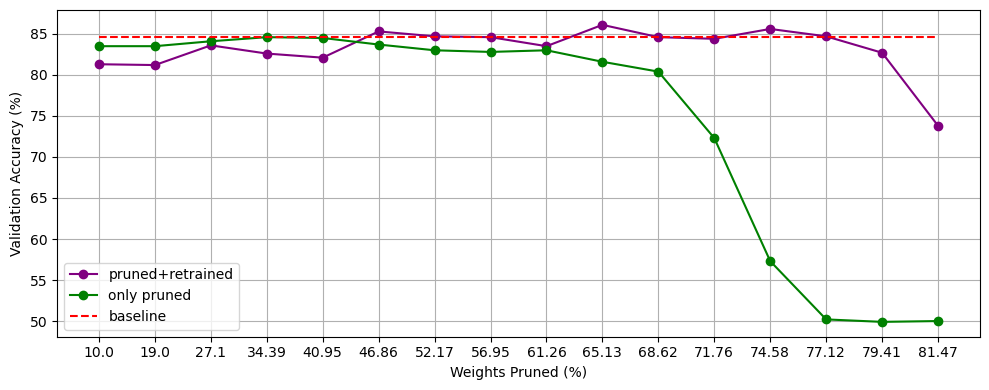

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(range(16), acc_hist, marker = 'o', color = 'purple', label = "pruned+retrained")
plt.plot(range(16), acc_hist_only_prune, marker = 'o', color = 'green', label = "only pruned")

plt.plot((baseline_acc_after_training+2)*np.ones(len(acc_hist)), '--', color = 'red', label = 'baseline')
plt.xticks(range(16), x_axis)
plt.grid()
plt.xlabel("Weights Pruned (%)")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.tight_layout()
plt.savefig("Acc VS %weights")

In [ ]:
def get_non_zero_weights(data):
    return data[data!=0]

In [ ]:
last_layer_weights = np.load("last_layer_weights.npy")
last_layer_weights_pruned = np.load('last_layer_weights_pruned.npy')
last_layer_weights_pruned_retrained = np.load("last_layer_weights_pruned_retrained.npy")


In [ ]:
last_layer_weights_pruned_non_zero = get_non_zero_weights(last_layer_weights_pruned)

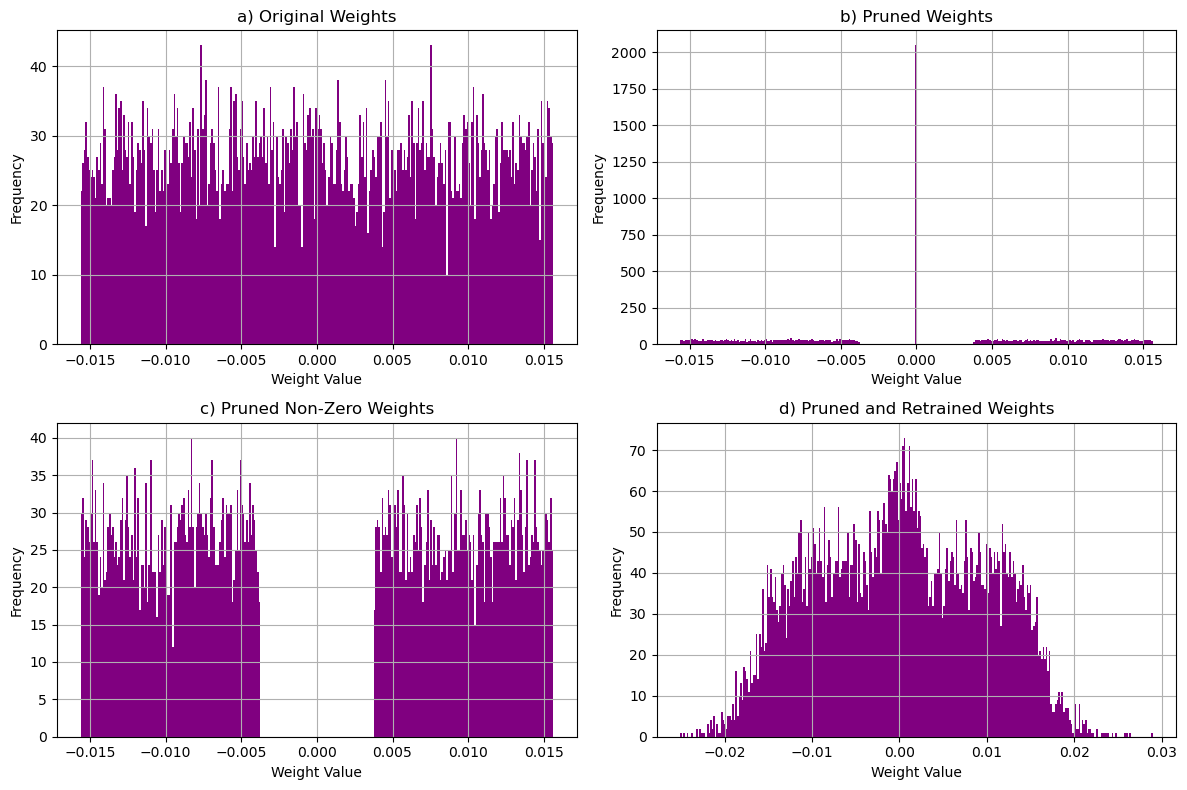

In [ ]:
import matplotlib.pyplot as plt

bins = 300

# Assuming you have these weight arrays:
# last_layer_weights, last_layer_weights_pruned, last_layer_weights_pruned_non_zero, last_layer_weights_pruned_retrained

# Create a figure with 2 rows and 2 columns (2x2 grid of subplots)
plt.figure(figsize=(12, 8))

# First subplot (1st row, 1st column)
plt.subplot(2, 2, 1)
plt.hist(last_layer_weights, bins=bins, color='purple', alpha=1)
plt.title('a) Original Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid()

# Second subplot (1st row, 2nd column)
plt.subplot(2, 2, 2)
plt.hist(last_layer_weights_pruned, bins=bins, color='purple', alpha=1)
plt.title('b) Pruned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid()

# Third subplot (2nd row, 1st column)
plt.subplot(2, 2, 3)
plt.hist(last_layer_weights_pruned_non_zero, bins=bins, color='purple', alpha=1)
plt.title('c) Pruned Non-Zero Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid()

# Fourth subplot (2nd row, 2nd column)
plt.subplot(2, 2, 4)
plt.hist(last_layer_weights_pruned_retrained, bins=bins, color='purple', alpha=1)
plt.title('d) Pruned and Retrained Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("Transfer_learning_weight_distribution_2x2_last_layer", dpi=300)

# Show all plots in the 2x2 grid
plt.show()


In [ ]:
baseline_all_weights = np.load("baseline_all_weights.npy")
pruned_retrained_all_weigths = np.load("pruned_retrained_all_weigths.npy")
pruned_retrained_non_zero_weigths = np.load("pruned_retrained_non_zero_weigths.npy")
only_pruned_all_weights = np.load("only_pruned_all_weights.npy")

In [ ]:
only_pruned_non_zero = get_non_zero_weights(only_pruned_all_weights)

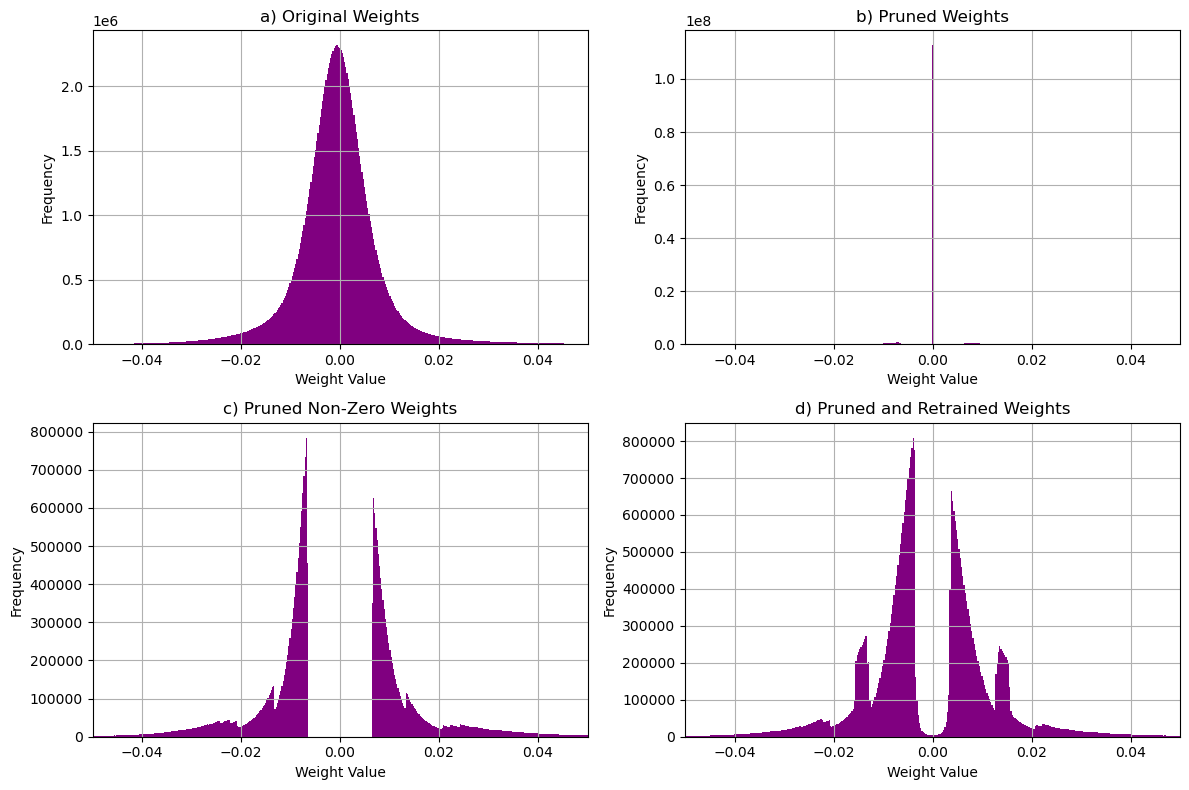

In [ ]:
import matplotlib.pyplot as plt

bins = 10000

# Assuming you have these weight arrays:
# last_layer_weights, last_layer_weights_pruned, last_layer_weights_pruned_non_zero, last_layer_weights_pruned_retrained

# Create a figure with 2 rows and 2 columns (2x2 grid of subplots)
plt.figure(figsize=(12, 8))

# First subplot (1st row, 1st column)
plt.subplot(2, 2, 1)
plt.hist(baseline_all_weights, bins=bins, color='purple', alpha=1)
plt.title('a) Original Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.xlim([-0.05, 0.05])
plt.grid()

# Second subplot (1st row, 2nd column)
plt.subplot(2, 2, 2)
plt.hist(only_pruned_all_weights, bins=bins, color='purple', alpha=1)
plt.title('b) Pruned Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.xlim([-0.05, 0.05])

plt.grid()

# Third subplot (2nd row, 1st column)
plt.subplot(2, 2, 3)
plt.hist(only_pruned_non_zero, bins=bins, color='purple', alpha=1)
plt.title('c) Pruned Non-Zero Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.xlim([-0.05, 0.05])

plt.grid()

# Fourth subplot (2nd row, 2nd column)
plt.subplot(2, 2, 4)
plt.hist(pruned_retrained_non_zero_weigths, bins=bins, color='purple', alpha=1)
plt.title('d) Pruned and Retrained Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.xlim([-0.05, 0.05])

plt.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("Transfer_learning_weight_distribution_2x2_all_wts", dpi=300)

# Show all plots in the 2x2 grid
plt.show()


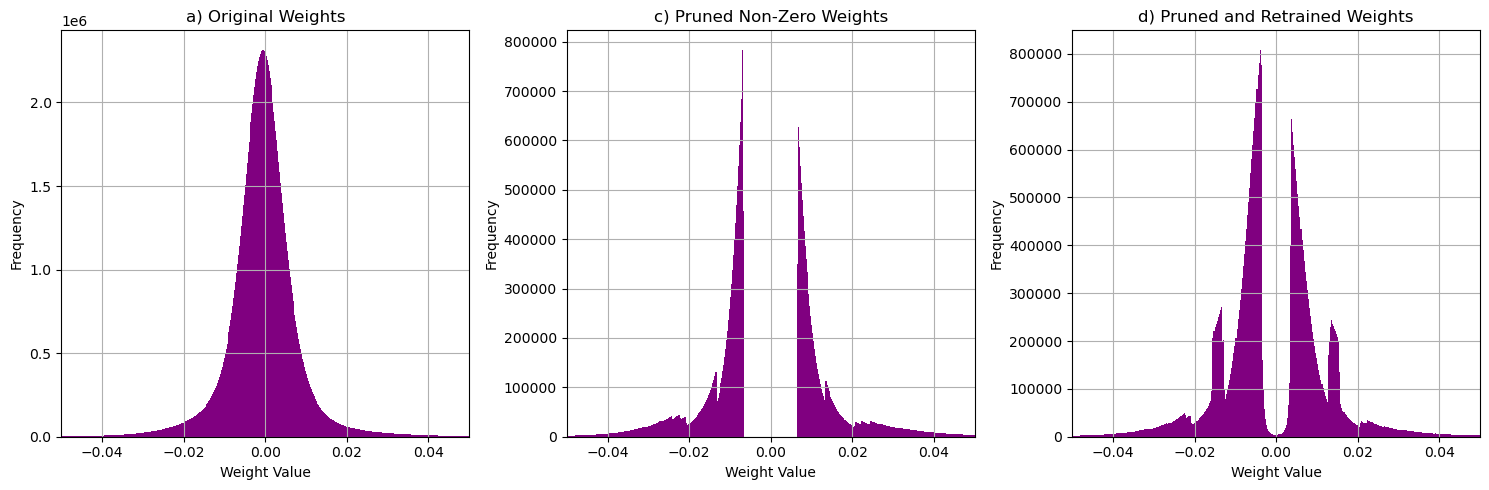

In [ ]:
import matplotlib.pyplot as plt

bins = 10000

# Assuming you have these weight arrays:
# last_layer_weights, last_layer_weights_pruned, last_layer_weights_pruned_non_zero, last_layer_weights_pruned_retrained

# Create a figure with 2 rows and 2 columns (2x2 grid of subplots)
plt.figure(figsize=(15, 5))

# First subplot (1st row, 1st column)
plt.subplot(1, 3, 1)
plt.hist(baseline_all_weights, bins=bins, color='purple', alpha=1)
plt.title('a) Original Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.xlim([-0.05, 0.05])
plt.grid()



# Third subplot (2nd row, 1st column)
plt.subplot(1,3 , 2)
plt.hist(only_pruned_non_zero, bins=bins, color='purple', alpha=1)
plt.title('c) Pruned Non-Zero Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.xlim([-0.05, 0.05])

plt.grid()

# Fourth subplot (2nd row, 2nd column)
plt.subplot(1, 3, 3)
plt.hist(pruned_retrained_non_zero_weigths, bins=bins, color='purple', alpha=1)
plt.title('d) Pruned and Retrained Weights')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.xlim([-0.05, 0.05])

plt.grid()

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig("Transfer_learning_weight_distribution_all_wts", dpi=300)

# Show all plots in the 2x2 grid
plt.show()
